In [49]:
"""In this article I will show you how you can split the market prices into different regimes 
(e.g. recession, stagnation and growth) and do an asset selection and allocation based on past 
price regimes and Sharpe ratios.
We will introduce a Success Ratio to represent number of growth periods to recession periods.
We will use k-means clustering to differentiate regimes and we will rerun the process several times in order to
make sure that we got correct latest regime and success rate.
We will assume that assets that historically were more often growing than falling will do so in future as well. 
And the same goes for risk adjusted returns. To get into more detail about risk reward for an asset we will 
calculate Sharpe ratios for each regime.
Having all this in place we will backtest the asset selection and asset allocation which we will benchmark against 
Dow Jones Industrial index and equally weighted allocation."""

#For calculation and data munging
import numpy as np
import pandas as pd

#For visualisation
import matplotlib.pyplot as plt
%matplotlib inline

#For data gathering
#import fix_yahoo_finance as fyf
#from pandas_datareader import data as pdr
from datetime import datetime

#For fun
from sklearn.cluster import KMeans

C:\Users\p998nkf\AppData\Local\conda\conda\envs\another_root\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: 
.resample() is now a deferred operation
You called pct_change(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead


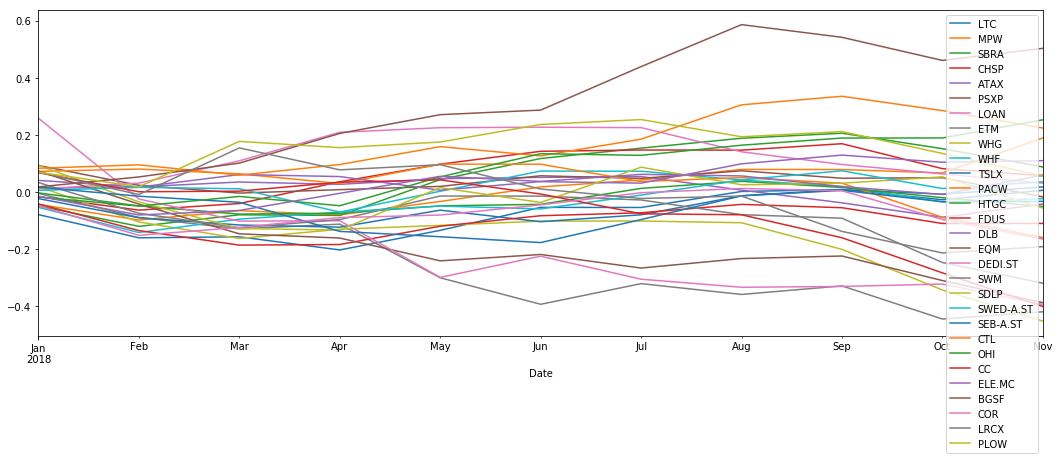

In [52]:
import os.path, time, datetime

pTime = str(time.strftime('%Y-%m-%d', time.gmtime(os.path.getmtime('asset_prices.csv'))))
tTime = str(datetime.date.today())

if tTime == pTime:
    assets = [
        'LTC','MPW','SBRA','CHSP','ATAX','PSXP','LOAN','ETM','WHG','WHF','TSLX','PACW',
        'HTGC','FDUS','DLB','EQM','DEDI.ST','SWM','SDLP','SWED-A.ST','SEB-A.ST','CTL',
        'OHI','CC','ELE.MC','BGSF','COR','LRCX','PLOW','FHLC','MHG.OL','XXL.OL','SALM.OL', 
        'ORK.OL'
    ]
    indexes =['^DJI']

    prices = pd.DataFrame(columns = assets)
    for a in assets:
        prices[a] = pdr.get_data_yahoo(a, start=datetime(2000,1,1))['Close']
    prices.to_csv('asset_prices.csv', encoding='utf-16')

    for b in indexes:
        prices[b] = pdr.get_data_yahoo(b, start=datetime(2000,1,1))['Close']
    benchmarks.to_csv('bench_prices.csv', encoding='utf-16')
else:
    #If we already have the prices up to date
    prices = pd.read_csv('asset_prices.csv', encoding='utf-16', index_col='Date',
                         parse_dates=True)
    prices.dropna(inplace=True)
    assets = prices.columns

    benchmarks = pd.read_csv('bench_prices.csv', encoding='utf-16', index_col='Date', 
                             parse_dates=True)
    benchmarks.dropna(inplace = True)
    indexes = benchmarks.columns
    
mPrices = prices.resample('M')
mPrices.pct_change().loc['2018'].cumsum().plot(figsize=(18,6))

In [53]:
def bCorr(asset, bench):
    df = pd.DataFrame({'A':asset, 'B':bench},index = asset.index)
    return df.corr()['A'][1]

In [63]:
def genSet(prices):
#This function will generate features that will be used for clustering
    df = pd.DataFrame(index = prices.index)
    
    df['Ret'] = np.log(prices/prices.shift(1))
    df['mRet'] = df['Ret'].rolling(21*3).mean()
    df['Ret5'] = df['Ret'].rolling(21*3).quantile(0.05)
    df['Ret50'] = df['Ret'].rolling(21*3).quantile(0.50)
    df['Ret95'] = df['Ret'].rolling(21*3).quantile(0.95)
    df['maxRet'] = df['Ret'].rolling(21*3).max()
    df['minRet'] = df['Ret'].rolling(21*3).min()

    df['Sigma'] = df['Ret'].rolling(21).std()
    df['mSigma'] = df['Sigma'].rolling(21*3).mean()
    df['maxSigma'] = df['Sigma'].rolling(21*3).max()
    df['minSigma'] = df['Sigma'].rolling(21*3).min()

    df['Drawdown'] = np.log(prices.shift(1)/prices.rolling(21*3).mean())
    df['Max/Current'] = np.log(prices/prices.rolling(21*3).max())
    
    df['MIN/MAX'] = np.exp(df['minRet']/df['maxRet'])/(np.exp(df['mRet']) - df['mSigma'])
    df['MIN/MAX SMA'] = df['MIN/MAX'].rolling(21).mean()
    df['MIN/MAX Cross'] = df['MIN/MAX'] - df['MIN/MAX SMA']
    
    df['REGIME'] = np.select([(df['Drawdown'] < df['Sigma']),\
                              (df['mRet'] > 2*df['maxSigma'])], [-1, 1], default=0)
    df.dropna(inplace=True)

    return df

In [64]:
def regime(prices, chart=False):
    df = genSet(prices)

    #We declare 3 clusters as we estimate 3 market regimes: Growth, Stagnation and
    #Recession
    kMeans = KMeans(n_clusters=3)
    kMeans.fit(df)

    df['reg'] = kMeans.labels_
    
    if chart:
        pd.DataFrame({'Asset':(prices-prices.mean())/prices.std(),\
                      'KMEANS':df['reg']}).dropna().plot(figsize=(18, 6))
        plt.show()
    
    regimes = df.groupby('reg')[['Ret', 'Sigma']].mean()

    minRet = regimes['Ret'].min()
    maxRet = regimes['Ret'].max()

    regimes['REGIMES'] = np.select([(regimes['Ret'] == minRet),\
                                    (regimes['Ret'] == maxRet)],\
                                   ['Recession','Growth'], default='Stagnation')

    df['reg'] = np.select([(df['reg']==regimes.index[0]),\
                           (df['reg']==regimes.index[1]),\
                           (df['reg']==regimes.index[2])],\
                          [regimes['REGIMES'][0],\
                           regimes['REGIMES'][1],regimes['REGIMES'][2]])

    growSharpe = df['Ret'].where(df['reg']=='Growth').mean()/\
    df['Sigma'].where(df['reg']=='Growth').mean()
    reccSharpe = df['Ret'].where(df['reg']=='Recession').mean()/\
    df['Sigma'].where(df['reg']=='Recession').mean()
    stagSharpe = df['Ret'].where(df['reg']=='Stagnation').mean()/\
    df['Sigma'].where(df['reg']=='Stagnation').mean()

    rr = df.groupby('reg')['Ret'].count()	
    success = rr.loc['Growth']/rr.loc['Recession']

    result = [df['reg'][-1], growSharpe, reccSharpe, stagSharpe, success, \
              df['Ret'].where(df['reg']=='Growth').count(),\
              df['Ret'].where(df['reg']=='Stagnation').count(),\
              df['Ret'].where(df['reg']=='Recession').count()]
    
    return result

In [ ]:
regime(prices['SEB-A.ST'], chart=True)

In [57]:
def gen_data(prices):

    #Building dataset for asset selection and allocation
    data = pd.DataFrame(index = prices.columns)

    data['Ret'] = (1+np.log(prices/prices.shift(1)).mean())**(252)-1
    data['Risk'] = prices.pct_change().std()*np.sqrt(252)
    data['Sharpe Ratio'] = (data['Ret']-0.001)/data['Risk']

    data['Regime'] = ''
    data['REG'] = 0
    data['G'] = 0.0
    data['S'] = 0.0
    data['R'] = 0.0
    data['Grow Sharpe'] = 0.0
    data['Fall Sharpe'] = 0.0
    data['Flat Sharpe'] = 0.0
    data['Success Ratio'] = 0.0

    for a in prices.columns:
    #defining values for variables used in this loop
        r, g, s = 0, 0, 0
        r1, r2, r3 = 0, 0, 0
        gS, rS, sS, succ = [], [], [], []

        for i in range(0, 20):

            #Getting regime data
            reg = regime(prices[a])

            #Stacking Sharpe Ratios per regime
            gS.append(reg[1])
            rS.append(reg[2])
            sS.append(reg[3])
            succ.append(reg[4])

            #Counting final regimes
            if reg[0] == 'Recession':
                r += 1
            elif  reg[0] == 'Growth':
                g += 1
            else:
                s += 1

            #Adding regime total counts in each trial
            r1 += reg[5]
            r2 += reg[6]
            r3 += reg[7]

    #Representing Regime Sharpe ratios as averages of all trials
        data.loc[a,'Grow Sharpe'] = np.mean(gS)
        data.loc[a,'Fall Sharpe'] = np.mean(rS)
        data.loc[a,'Flat Sharpe'] = np.mean(sS)
        data.loc[a,'Success Ratio'] = np.mean(succ)

    #Assigninging regimes based on which one got the most hits
        if g > max([r, s]):
            data.loc[a,'Regime'] = 'Growth'
            data.loc[a,'REG'] = 1
        elif s > max([r, g]):
            data.loc[a,'Regime'] = 'Stagnation'
            data.loc[a,'REG'] = 0
        else:
            data.loc[a,'Regime'] = 'Recession'
            data.loc[a,'REG'] = -1

    #Calculating how often we got each regime:
    #G = Growth
    #S = Stagnation
    #R = Recession
        data.loc[a,'G'] = r1 / sum([r1, r2, r3])
        data.loc[a,'S'] = r2 / sum([r1, r2, r3])
        data.loc[a,'R'] = r3 / sum([r1, r2, r3])

    #Determening and scaling Sharpes per regime
    g = data['Grow Sharpe'].sum()
    r = data['Fall Sharpe'].sum()
    s = data['Flat Sharpe'].sum()

    data['Grow Sharpe'] = data['Grow Sharpe']/g
    data['Fall Sharpe'] = data['Fall Sharpe']/r
    data['Flat Sharpe'] = data['Flat Sharpe']/s

    return data

In [84]:
def portfolio_manager(prices, x_date=2018-12-31, max_assets=100):
    data = gen_data(prices)
    print('Received data with price regimes')

    allocators = data[['Success Ratio','REG','G','Grow Sharpe','R','Fall Sharpe',\
                       'S','Flat Sharpe','Sharpe Ratio']]
    print('Allocation determinats picked')

    allocators['Score'] = data['Success Ratio'] + data['REG']\
        + np.multiply(data['G'].values + 1, data['Grow Sharpe'].values)\
        + np.multiply(data['R'].values + 1, data['Fall Sharpe'].values)\
        + np.multiply(data['S'].values + 1, data['Flat Sharpe'].values)\
        + data['Sharpe Ratio']
    
    print(data[['Success Ratio', 'Regime', 'REG']])
    
    #Creating allocation
    if data.where((data['Regime'] != 'Recession') & (data['REG'] >= 0)).dropna()['REG'].count() >= 3:
        data['Allocation'] = allocators['Score']
        print('Actual allocation coefficients: \n{}'.format(data['Allocation']))
    else:
        print('No selection was done because there were no good assets to choose from.\n{}'\
              .format(prices.index[-1]))
        
        #Creating allocation without any selection
        data['Allocation'] = (data['Ret']/np.sum(data['Ret']))*data['G'].values
        print('Actual allocation coefficients: \n{}'.format(data['Allocation']))
        
    #We assume we cannot short an asset so we drop any allocation that is below 0.0
    data['Allocation'] = data['Allocation'].where(data['Allocation'] > 0.0).fillna(0)
    print(data)
    
    #The maximum amount of assets is relevant for small investors like me. 
    #More assets demand more money for
    #investing...so you choose your number :)
    print(len(data.where(data['Allocation'] > 0.0).dropna().index))
    if len(data.where(data['Allocation'] > 0.0).dropna().index) > max_assets:
        q = 1 - max_assets/len(data.index)
        success = data['Ret'].quantile(q)
        print(q, success)
        data = data.where(data['Ret'] > success).fillna(0)

    data['Allocation'] = np.round(data['Allocation']/data['Allocation'].sum(), 4)
    data.drop(['Grow Sharpe','Flat Sharpe','Fall Sharpe'], axis=1, inplace=True)
    data.fillna(0, inplace=True)

    print(data)
    return data['Allocation']

In [83]:
#Now we can check our implementation in backtest
returns = pd.DataFrame(columns=assets)

for i in mPrices.index[-12:]:
    if i in prices.index:
        print(i)
        ii = list(prices.index).index(i)
        if len(prices.index[:-ii]) > 21*3 and len(benchmarks.index[:-ii]) > 21*3:
            portfolio = portfolio_manager(prices[:-ii], x_date = i, max_assets=10)

            returns.loc[i, portfolio.values.T]

print(returns)

C:\Users\p998nkf\AppData\Local\conda\conda\envs\another_root\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  after removing the cwd from sys.path.


2018-01-31 00:00:00
Received data with price regimes
Allocation determinats picked
           Success Ratio      Regime  REG
LTC             1.700000   Recession   -1
MPW             2.181818   Recession   -1
SBRA            0.153846      Growth    1
CHSP            4.500000      Growth    1
ATAX            2.769231   Recession   -1
PSXP            0.581395  Stagnation    0
LOAN            0.307692  Stagnation    0
ETM             1.083333  Stagnation    0
WHG             1.629630  Stagnation    0
WHF             0.244898   Recession   -1
TSLX            4.272727      Growth    1
PACW            1.148148  Stagnation    0
HTGC            0.459459   Recession   -1
FDUS            2.166667   Recession   -1
DLB             1.360000  Stagnation    0
EQM             1.040422   Recession   -1
DEDI.ST         0.209677  Stagnation    0
SWM             4.285714   Recession   -1
SDLP            3.500000      Growth    1
SWED-A.ST       2.583333  Stagnation    0
SEB-A.ST        0.166667  Stagnatio

C:\Users\p998nkf\AppData\Local\conda\conda\envs\another_root\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


KeyError: 'Allocation'